In [1]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import io
import os
import math

# Metadatos
import xmltodict

# Data frame
import pandas as pd

# Para las imágenes TIF
import tifffile as tf


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Ruta de las imágenes de villaseca
camino = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Vuelos/Villafranca 2do vuelo'


# Ejemplo de extracción de metadata con TiffFile

Función con TiffFile para extracción de metadatos de imágenes TIFF. Tras este ejemplo, se sacará la temperatura del sensor de todas las imagenes y se graficará.

## Función temperatura, desviación estándar y temperatura de sensor

Función que como output devuelve los índices de cada imagen, la media de temperatura en grados de cada imagen, su desviación estándar y la temperatura del sensor. Devuelve 4 listas que vendrán bien para graficarlas con la función graf().

In [3]:
# Temperatura y desviación estándar y temperatura del sensor
def MeanStdTif(tif_path):
    '''
    Función que grafica la media, desviación estándar y temperatura del sensor
    de cada imagen TIF almacenada en un directorio dado.
    '''
    # Se define la lista donde se almacenarán las medias y las varianzas
    med = []
    stdesv = []
    nombres = []
    sensor = []
    
    # Se extraen las rutas TIFF
    for fname in sorted(os.listdir(tif_path)):
        if fname.endswith('tif'):
            
            # Extracción media y varianza de la imagen
            imag = tf.imread(os.path.join(tif_path, fname))
            media = np.mean(imag)
            desviacion = np.std(imag)
            med.append(media)
            stdesv.append(desviacion)
            nombres.append(fname)
            
            
            # Extracción temperatura de sensor
            
            # Cogemos info de la imagen
            tif = tf.TiffFile(os.path.join(tif_path, fname))

            # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "XMP":

                        # Extracción del XML total
                        dict_tot = xmltodict.parse(tag_value)

                        # Extracción del diccionario anidado con los datos que nos interesan
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        sens = float(dict2['@Camera:SensorTemperature'])
                        sensor.append(sens)
                        
            
    return list(range(0+1,len(nombres)+1)), med, stdesv, sensor
            

## Se crea una función que de como output un CSV con los datos de cada imagen y sus metadatos más importantes

Esta función podrá procesar todas las imágenes térmicas TIFF que se encuentren en el directorio, así como corregirlas según la distancia de la cámara al objeto, la temperatura ambiental y la humedad relativa (TODAVÍA EN DESARROLLO) así como generar un excel si se indica. En el excel se incluyen datos de las imágenes tales como la temperatura media de cada una, su desviación estándar y diversos metadatos de interés.

In [4]:

def csv_img(tif_path, results_dir, csv = False):
    '''
    Función que tomará las imágenes TIF de un directorio y colocará 
    valores como la media y la desviación estándar y otros metadatos en un data frame
    guardado en CSV, también se corregirán los valores de temperatura.
    
    tif_path = directorio donde se encuentran las imágenes a procesar.
    
    results_dir = directorio a donde se quiere enviar el CSV.
    
    csv = True si se quiere generar un CSV con los resultados.
    
    correction = True si se quiere corregir las imagenes con los parámetros atmosféricos (EN DESARROLLO).
    
    '''
    names = []
    mean = []
    stdesv = []
    temp_sensor = []
    pitch = []
    roll = []
    yaw = []
    time = []
    altitud = []
    
    # Se extraen las rutas TIFF
    for fname in sorted(os.listdir(tif_path)):
        if fname.endswith('tif'):
            
            # Se guarda el nombre de la imagen
            names.append(fname)
            
            # Extracción del array con las temperaturas en crudo
            imag = tf.imread(os.path.join(tif_path, fname))

            # Extracción desviación y media
            media = round(np.mean(imag),2)
            desv = round(np.std(imag),2)
            mean.append(media)
            stdesv.append(desv)
            
            # Extracción de metadatos de interés 
            tif = tf.TiffFile(os.path.join(tif_path, fname))
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "XMP":
                        dict_tot = xmltodict.parse(tag_value)
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        
                        # Temperatura del sensor
                        sens = float(dict2['@Camera:SensorTemperature'])
                        temp_sensor.append(sens)
                        
                        # Pitch
                        ptch = float(dict2['@Camera:Pitch'])
                        pitch.append(ptch)
                        
                        # Roll
                        rll = float(dict2['@Camera:Roll'])
                        roll.append(rll)
                        
                        # Yaw
                        yw = float(dict2['@Camera:Yaw'])
                        yaw.append(yw)
                        

                    if tag_name == 'ExifTag':
            
                        time.append(tag_value['DateTimeOriginal'])
                
                    
                    if tag_name == "GPSTag":
                        altitud.append(tag_value['GPSAltitude'][0])
                    
                    
                        
                     
            data_frame = pd.DataFrame({'nombre_imagen': names,'Hora':time,
                   'media': mean,
                   'desviacion_tipica': stdesv, 'temperatura_sensor': temp_sensor, 'pitch': pitch, 
                        "roll":roll, "yaw": yaw})
            
            if csv == True:
            
                data_frame.to_csv(path_or_buf = results_dir)
                
            else:
                pass
            
    return data_frame
    

csv para los datos de trigo

In [5]:
# Se guardan los csv de todas las imágenes de los vuelos sobre trigo
secano_total = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\Prácticas curriculares\Proyecto\Imágenes Vuelo\converted_secano\converted'
regadio_total = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\Prácticas curriculares\Proyecto\Imágenes Vuelo\converted_regadio\converted'
results_dirSec = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Algoritmos/Open_TIFF/Results/open_tifSec.csv'
results_dirReg = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Algoritmos/Open_TIFF/Results/open_tifReg.csv'
results_dirVill = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Algoritmos/Open_TIFF/Results/open_tifVill.csv'
secanoData = csv_img(secano_total, results_dirSec, csv = True)
regadioData = csv_img(regadio_total, results_dirReg, csv = True)
villasecaData = csv_img(camino, results_dirVill, csv = True)

A partir de aquí, se usan los datasets de todas las imágenes

In [6]:
villasecaData

,nombre_imagen,Hora,media,desviacion_tipica,temperatura_sensor,pitch,roll,yaw
0,IX-12-66264_0008_0001_THM.tif,2021:05:25 09:35:31,25.150000,4.92,27.4,8.176189,-9.630278,-115.124229
1,IX-12-66264_0008_0002_THM.tif,2021:05:25 09:35:32,24.920000,5.00,27.4,6.945594,-2.364251,-118.588097
2,IX-12-66264_0008_0003_THM.tif,2021:05:25 09:35:33,24.690001,4.93,27.4,6.702036,-3.289108,-115.994225
3,IX-12-66264_0008_0004_THM.tif,2021:05:25 09:35:35,24.549999,4.67,27.4,8.910656,-4.448862,-116.009087
4,IX-12-66264_0008_0005_THM.tif,2021:05:25 09:35:36,23.889999,4.49,27.4,8.759966,-3.266087,-117.007027
...,...,...,...,...,...,...,...,...
668,IX-12-66264_0008_0670_THM.tif,2021:05:25 10:09:23,20.230000,4.07,28.3,4.026732,-4.021675,64.885399
669,IX-12-66264_0008_0671_THM.tif,2021:05:25 10:09:25,21.280001,4.53,28.3,4.655810,4.011206,64.381538
670,IX-12-66264_0008_0672_THM.tif,2021:05:25 10:09:26,21.459999,4.63,28.3,3.906769,-1.007033,66.550301
671,IX-12-66264_0008_0673_THM.tif,2021:05:25 10:09:28,21.830000,4.25,28.3,7.677195,-2.155737,67.272980


## Se utiliza la función graf()

La función grafica las cuatro listas obtenidas de la función MeanStdTif() para poder visualizar la tendencia de la temperatura de cada imagen así como la temperatura del sensor

In [7]:
# Se define la función
def graf(listaY1, listaY2, listaY3, save = False):
    
    '''
    Función que muestra un gráfico con la media de temperatura de cada imagen,
    su desviación estándar y la temperatura del sensor en cada imagen.
    
    listaX = Índices a utilizar en el eje de las X
    listaY1 = Lista con las medias de temperatura de las imágenes
    ListaY2 = Lista con las desviaciones estándar de las imágenes
    ListaY3 = Lista con las temperaturas del sensor
    
    '''
    
    plt.plot(listaY1,'-',linewidth=2,color=(0.2,0.1,0.4), label="Media ºC")
    plt.plot(listaY2,'-',linewidth=2,color='g', label="Desviación estándar ºC")
    plt.plot(listaY3, color='r', label = "Temperatura del sensor ºC")
    plt.grid()
    
    plt.xlabel('Imagen')
    plt.ylabel('Temperatura ºC')
    plt.ylim([0,40])
    plt.title('Media, std, Temperatura del sensor')
    plt.legend(loc="best")
    
    if save == True:
        plt.savefig('total', dpi = 300)
        
    plt.show()
    
    
    

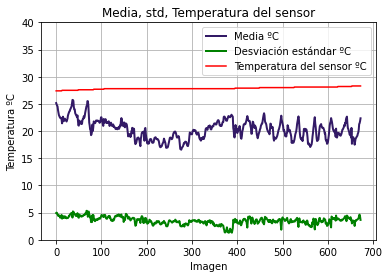

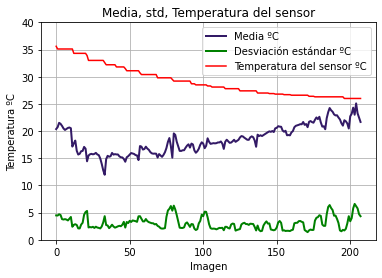

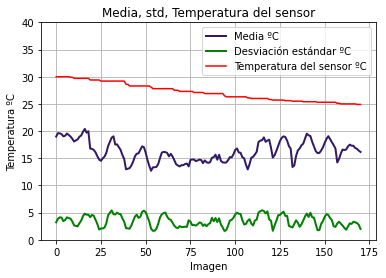

In [8]:
graf( villasecaData['media'], villasecaData['desviacion_tipica'], villasecaData['temperatura_sensor'], save = True)
graf( regadioData['media'], regadioData['desviacion_tipica'], regadioData['temperatura_sensor'], save = True)
graf( secanoData['media'], secanoData['desviacion_tipica'], secanoData['temperatura_sensor'], save = True)

## Temperatura media de las imágenes Vs Temperatura sensor

Función creada para graficar la relación existente entre la temperatura del sensor y la temperatura obtenida por la cámara térmica (EN DESARROLLO - BUSCANDO PATRONES DE LA RELACIÓN ENTRE AMBAS TEMPERATURAS).

- La primera función ofrece la opción de elegir el subconjunto de imágenes a comparar contra la temperatura del sensor en el momento en el que se tomó cada imagen. La gráfica muestra en el eje X la temperatura media de cada imagen y en el eje Y el divisor de la división de la temperatura del sensor por la temperatura media de la imagen.

- La segunda función funciona de la siguiente manera: Con las 200 últimas imágenes (Son las que tenemos certeza de que el sensor en ese momento está estabilizado) se calcula tanto la media de la media de la temperatura de cada imagen como la media de la temperatura del sensor de esas 200 imagenes. Tras esto, se trabaja a partir de ahora con todas las imágenes, se restará la temperatura media de cada imagen a la media de las medias de las 200 últimas imágenes (EJe Y) mientras que el resultado de la resta de la temperatura del sensor de cada imagen menos la temperatura media del sensor de las últimas 200 imágenes se dispondrá en el Eje X.

In [11]:
def TempVsSensor(temp_imag, temp_sensor, conj, save = False):
    '''
    Gráfico con la Media de las temperaturas de un conjunto de imágenes (conj y temp_imag respectivamente) contra  
    la temperatura del sensor (temp_sens). Temperatura relativa Vs Temperatura media
    '''
    
    subconj_sens, subconj_img = temp_sensor[:conj],temp_imag[:conj]
    division = [i / j for i, j in zip(subconj_sens, subconj_img)]
    
    plt.plot(subconj_img,division, 'o',linewidth=2,color=(0.8,0.1,0.0), label="Tª relativa Vs. Tº media de la imagen")
    plt.grid()
    plt.xlabel('Temperatura media de cada imagen')
    plt.ylabel('Tª sensor/Tª media imagen')
    plt.title('TempVsSensor con '+ str(conj) +' primeras imágenes' )
    plt.legend(loc="best")
    
    if save == True:
    # Guarda la imagen
        plt.savefig('tempVssensor', dpi = 300)
    plt.show()
    
    

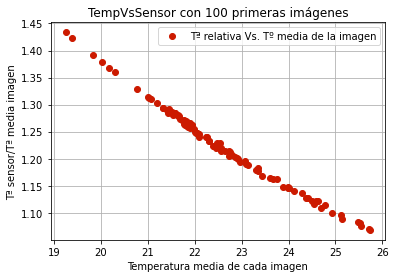

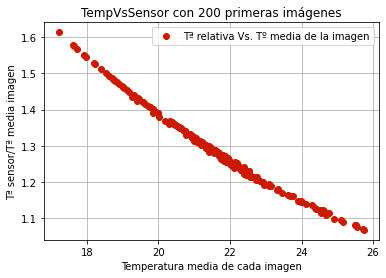

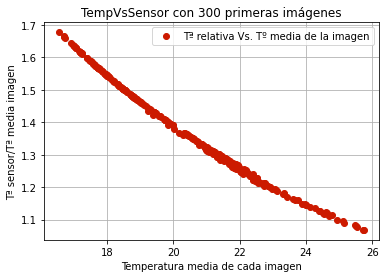

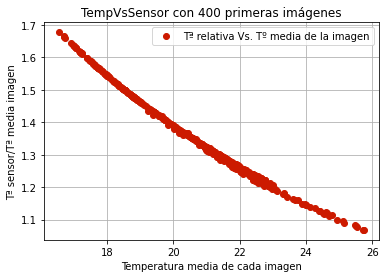

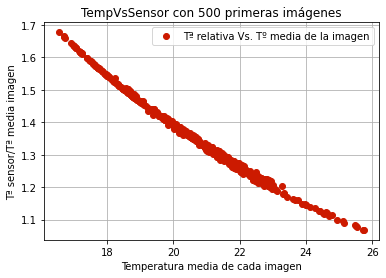

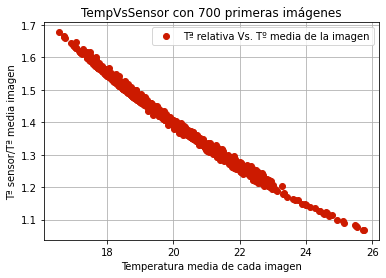

In [12]:
# Probando la función con subconjuntos de las 100, 200, 300, 400, 500 y 600 imágenes respectivamente para los datos de Villaseca
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 100)
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 200, save = True)
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 300)
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 400)
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 500)
TempVsSensor(villasecaData['media'], villasecaData['temperatura_sensor'], conj = 700)

# Se comparan las temperaturas reales de las telas con las temperaturas captadas por la cámara

Para esta sección es necesario tener un excel con las temperaturas hipotéticas de las telas extraídas con Qgis en un sheet y las temperaturas reales medidas con termómetro en otro sheet.

In [13]:
# Directorio donde irá el csv resultante
output = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Algoritmos\Open_TIFF\Results'

# Directorios con las imágenes de las telas para extraer los metadatos e incluirlos en los csv
regadio_tif = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Temp telas\Ensayo trigo\NombreImgRegTelas'
secano_tif = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Temp telas\Ensayo trigo\NombreImgSecTelas'
villaseca_tif= r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Vuelos\Villafranca 2do vuelo\telas'

# Excels con las temperaturas hipotéticas de cada tela (Qgis) y temperatura real
regadio_excel =r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\Temp_regadio.xlsx'
secano_excel = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\Temp_secano.xlsx'
villaseca_excel ='C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Datos a utilizar TFM/Excels en bruto/Temp_telasVillafranca.xlsx'

# Temp ambiental y emisividad
bg_regadio = -33.9
bg_secano = -38
bg_villaseca = -27.905
emissiv = 0.98

# Nombre de los sheet
sheet_duet = 'Telas_duet'

# Nombre de cada csv producido
name_v = 'villasecTelasData.csv'
name_r = 'regadioTelasData.csv'
name_s = 'secanoTelasData.csv'


In [14]:
def csv_toTelas(img_path, excel_path, sheet_duet, emiss, Tbg,nombre):
    '''
    Se genera un CSV con los datos de temperatura corregidos atmosféricamente con la ley de Stefan-Boltzann así como otras variables 
    de metadatos.
    img_path = Directorio donde se encuentran las imágenes en las que salen las telas
    excel_path = Directorio donde se encuentran los excels con la temperatura hipotética y real de las telas (las temperaturas reales extraídas con un programa como Qgis)
    sheet_duet = Sheet con las temperaturas hipotéticas
    emiss = Emisividad
    Tbg = Temperatura ambiente
    Nombre = Nombre del CSV resultante
    
    CON ESTOS DATASETS SE HACEN LOS ANÁLISIS ESTADÍSTICOS
    
    Indicación. Según el número de telas, se tendrá que indicar cuantas veces se guardan los metadatos
    '''
    
    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    
    # Columnas
    name = []
    hora = []
    tipo_tela = []
    temp_no_corr = []
    temp_corr = []
    temp_sensor = []
    image_time = []
    altitud = []
    coordX = []
    coordY = []
    yaw = []
    roll = []
    pitch = []
    
    tipo_tela = df['tela']
    
   
    for fname in sorted(os.listdir(img_path)):
        if fname.endswith('tif'):
            name.append(fname)
            name.append(fname)
            
            

            tif = tf.TiffFile(os.path.join(img_path, fname))

    # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "ExifTag":
                        
                        hora.append(tag_value['DateTimeOriginal'])
                        hora.append(tag_value['DateTimeOriginal'])
                        
                        
                        
                    elif tag_name == "XMP":
                        dict_tot = xmltodict.parse(tag_value)
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        
                        # Temperatura del sensor
                        sens = float(dict2['@Camera:SensorTemperature'])
                        temp_sensor.append(sens)
                        temp_sensor.append(sens)
                        
                       
                        
                        # Pitch
                        ptch = float(dict2['@Camera:Pitch'])
                        pitch.append(ptch)
                        pitch.append(ptch)
                        
                        
                        
                        
                        # Roll
                        rll = float(dict2['@Camera:Roll'])
                        roll.append(rll)
                        roll.append(rll)
                        
            
                        
                        # Yaw
                        yw = float(dict2['@Camera:Yaw'])
                        yaw.append(yw)
                        yaw.append(yw)
                        
                
                    
                    elif tag_name == "GPSTag":
                        altitud.append(tag_value['GPSAltitude'][0]/tag_value['GPSAltitude'][1])
                        altitud.append(tag_value['GPSAltitude'][0]/tag_value['GPSAltitude'][1])
                        

                        

                            
                            
                            
    # La media de temperatura de cada tela
    temp_no_corr = df['mean']
    
    Kbg = Tbg + 273
        
    # Corrección telas sensor 
    for i in temp_no_corr:
            
        # Conversión a Kelvin
        K = i + 273.0
            
        # Corrección atmosférica
        corr = ((K**4.0 - (1.0-emiss)*Kbg**4.0)/emiss)**(1/4)
            
        # Transformación a grados
        grad = corr - 273.0
        
        # Lista de la temperatura corregida
        temp_corr.append(grad)
    
    
    # Coordenadas
    centroX = 32.32
    centroY = 25.378
    coordXn = df['coordenada_x']
    coordYn = df['coordenada_y']
    x = float()
    for i in coordXn:
        x = i - centroX
        coordX.append(x)
        
    
    y = float()
    for j in coordYn:
        y = j - centroY
        coordY.append(y)
        
        
    df2 = pd.DataFrame({'Nombre': name, 'Hora': hora, 'Tipo_tela': tipo_tela, 'Temp_no_corr':temp_no_corr, 
                      'Temp_corr': temp_corr, 'Temp_sensor': temp_sensor, 'Altitud': altitud, 'CoordX': coordX,
                      'CoordY': coordY, 'Yaw': yaw, 'Roll': roll, 'Pitch':pitch})
    df2.to_csv(nombre + '.csv')
    return df2


In [15]:
# Se aplica la función, los metadatos se repiten dos veces (dos tipos de tela)
df_reg = csv_toTelas(regadio_tif, regadio_excel, sheet_duet, emissiv, bg_regadio,name_r)
df_sec = csv_toTelas(secano_tif, secano_excel, sheet_duet, emissiv, bg_secano,name_s)
df_sec

,Nombre,Hora,Tipo_tela,Temp_no_corr,Temp_corr,Temp_sensor,Altitud,CoordX,CoordY,Yaw,Roll,Pitch
0,IX-12-66264_0006_0030_THM.tif,2021:05:13 09:29:57,Blanca,12.289454,13.071660,29.2,348.1643,-20.279,-15.866,-83.606491,-2.802272,6.886898
1,IX-12-66264_0006_0030_THM.tif,2021:05:13 09:29:57,Negra,28.682399,29.650211,29.2,348.1643,-20.701,-18.670,-83.606491,-2.802272,6.886898
2,IX-12-66264_0006_0031_THM.tif,2021:05:13 09:29:59,Blanca,13.056887,13.848321,29.2,348.1837,-20.454,-5.032,-79.449066,-3.960315,6.244649
3,IX-12-66264_0006_0031_THM.tif,2021:05:13 09:29:59,Negra,29.955824,30.937139,29.2,348.1837,-21.285,-8.021,-79.449066,-3.960315,6.244649
4,IX-12-66264_0006_0032_THM.tif,2021:05:13 09:30:00,Blanca,11.912879,12.690537,29.2,348.2710,-25.401,7.168,-78.599426,-8.539973,6.667879
5,IX-12-66264_0006_0032_THM.tif,2021:05:13 09:30:00,Negra,29.423141,30.398822,29.2,348.2710,-26.235,3.665,-78.599426,-8.539973,6.667879
6,IX-12-66264_0006_0033_THM.tif,2021:05:13 09:30:02,Blanca,11.349732,12.120561,29.2,347.9198,-23.916,23.455,-81.638527,0.246728,6.443981
7,IX-12-66264_0006_0033_THM.tif,2021:05:13 09:30:02,Negra,27.859622,28.818646,29.2,347.9198,-24.749,20.011,-81.638527,0.246728,6.443981
8,IX-12-66264_0006_0050_THM.tif,2021:05:13 09:30:52,Blanca,10.849070,11.613801,28.3,346.0805,15.329,-9.381,68.297546,7.485509,8.807389
9,IX-12-66264_0006_0050_THM.tif,2021:05:13 09:30:52,Negra,29.871481,30.851906,28.3,346.0805,14.053,-6.144,68.297546,7.485509,8.807389


In [16]:
# Se aplica la función, los metadatos se repiten cuatro veces (cuatro tipos de tela) (En este caso da error porque no se ha 
# puesto cuatro veces cada metadato)
df_villa = csv_toTelas(villaseca_tif, villaseca_excel, sheet_duet, emissiv, bg_villaseca,name_v)
df_villa

ValueError: arrays must all be same length

# Gráficos temporales

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import dateutil

def telas_func(tipo_tela, img_path, excel_path, sheet_duet,sheet_termo, name):
    
    '''
    Función que muestra un gráfico de puntos con los datos de temperatura de cada imágen en cada momento horario junto con los datos
    de temperaturas reales también organizados por tiempo en el que se recogieron.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    - sheet_termo = Sheet del excel donde se encuentran los datos reales
    
    Output:
    -Gráfico de puntos
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_termo = pd.read_excel(excel_path, sheet_name = sheet_termo)
    

    image_time = []

    # Aquí, se extraen las horas de las imágenes tomadas
    for fname in sorted(os.listdir(img_path)):
        if fname.endswith('tif'):

            tif = tf.TiffFile(os.path.join(img_path, fname))

    # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "ExifTag":




                        # Se añaden a la lista en formato hora, minutos y segundos

                        image_time.append(tag_value['DateTimeOriginal'])


    # Temperatura del sensor también

            sensor = []
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "XMP":

                        # Extracción del XML total
                        dict_tot = xmltodict.parse(tag_value)

                        # Extracción del diccionario anidado con los datos que nos interesan
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        sens = float(dict2['@Camera:SensorTemperature'])
                        sensor.append(sens)


    horas = [dateutil.parser.parse(s) for s in image_time]
    

    # Aquí, se crea la lista con las horas de las medidas con termómetro así como las temperaturas
    termo_time = df_termo['Hora']
    horas_termo = [dateutil.parser.parse(s) for s in termo_time]

    temp_real = df_termo[tipo_tela]
    plt.plot(horas, df[df['tela'] == tipo_tela]['mean'],'.', label = 'Temperatura Duet-T')
    plt.plot(horas_termo, temp_real,'o', label = 'Temperatura termómetro')
    #plt.plot(horas, sensor, label = 'Temperatura del sensor')
    
    plt.title(name+ ' ' + tipo_tela)
    plt.legend(loc="best")
    plt.xticks(rotation=45, ha="right")
    plt.grid()
    plt.savefig(name + ' ' + tipo_tela+ ' tempR_tempDuet.png', dpi = 300)
    plt.show()
    
    
# Misma función que toma los datos del excel
def telas_funcXLSX(tipo_tela, excel_path, sheet_duet,sheet_termo, name):
    
    '''
    Función que muestra un gráfico de puntos con los datos de temperatura de cada imágen en cada momento horario junto con los datos
    de temperaturas reales también organizados por tiempo en el que se recogieron.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    - sheet_termo = Sheet del excel donde se encuentran los datos reales
    
    Output:
    -Gráfico de puntos
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_termo = pd.read_excel(excel_path, sheet_name = sheet_termo)

    time = df[df['tela'] == tipo_tela]['Hora']


    horas = [dateutil.parser.parse(s) for s in time]
    

    # Aquí, se crea la lista con las horas de las medidas con termómetro así como las temperaturas
    termo_time = df_termo['Hora']
    
    # A hora UTC
    horas_termo = [dateutil.parser.parse(s) for s in termo_time]

    temp_real = df_termo[tipo_tela]
    plt.plot(horas, df[df['tela'] == tipo_tela]['mean'],'.', label = 'Temperatura Duet-T')
    plt.plot(horas_termo, temp_real,'o', label = 'Temperatura termómetro')
    
    plt.title(name+ ' ' + tipo_tela)
    plt.legend(loc="best")
    plt.xticks(rotation=45, ha="right")
    plt.grid()
    #plt.savefig(name + ' ' + tipo_tela+ ' tempR_tempDuet.png', dpi = 300)
    plt.show()
    
    
    return


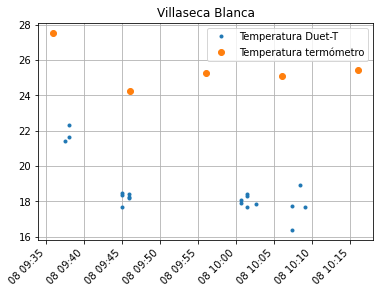

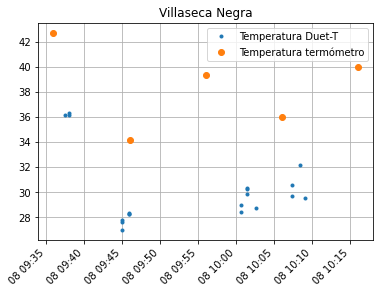

In [23]:
# Excel con las temperaturas 
telas_path = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Datos a utilizar TFM/Excels en bruto/Temp_telasVillafranca.xlsx'
# Directorio donde se encuentran las imágenes de las telas
telas_img = 'C:/Users/Usuario/Documents/Máster Bioinformática y Bioestadística/Segundo semestre/TFM/Vuelos/Villafranca 2do vuelo/telas'

regadio_tif = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Temp telas\Ensayo trigo\NombreImgRegTelas'
secano_tif = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Temp telas\Ensayo trigo\NombreImgSecTelas'

regadio_excel =r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\Temp_regadio.xlsx'
secano_excel = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\Temp_secano.xlsx'
telas_func('Blanca', telas_img, telas_path, 'Telas_duet', 'Telas_reales', 'Villaseca')
telas_func('Negra', telas_img, telas_path, 'Telas_duet', 'Telas_reales', 'Villaseca')
#telas_func('Árbol', telas_img, telas_path, 'Telas_duet', 'Telas_reales', 'Villaseca')
#telas_func('Suelo', telas_img, telas_path, 'Telas_duet', 'Telas_reales', 'Villaseca')

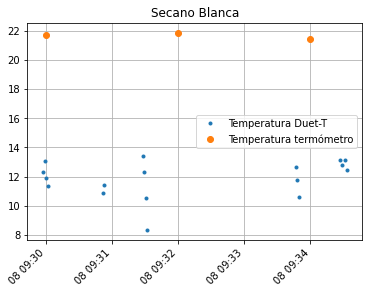

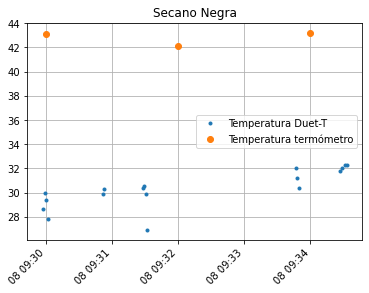

In [24]:
# Trigo Secano con XLSX
excel_s = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Temp_Secano.xlsx'
sheet = 'Telas_duet'
sheTermo = 'Telas_reales'
telas_funcXLSX("Blanca", excel_s, sheet,sheTermo, 'Secano')
telas_funcXLSX("Negra", excel_s, sheet,sheTermo, 'Secano')

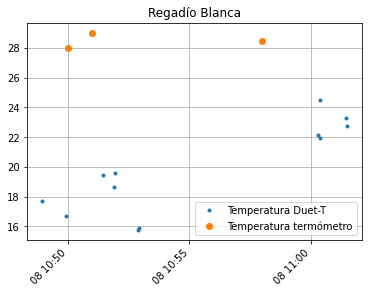

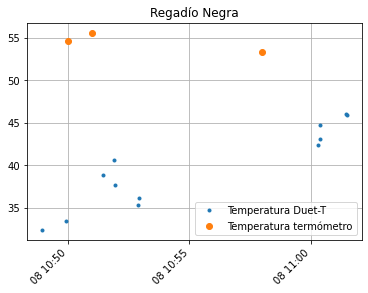

In [25]:
# Trigo secano
excel_r = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Temp_Regadio.xlsx'
sheet = 'Telas_duet'
sheTermo = 'Telas_reales'
telas_funcXLSX("Blanca", excel_r, sheet,sheTermo, 'Regadío')
telas_funcXLSX("Negra", excel_r, sheet,sheTermo, 'Regadío')

# Boxplot con los datos de las telas agrupados

Los datos se agrupan en 4 como se puede observar en los gráficos de puntos.

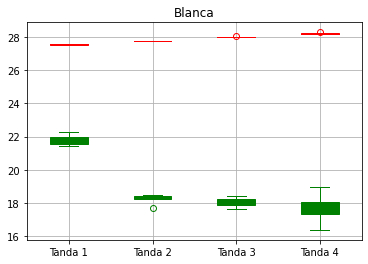

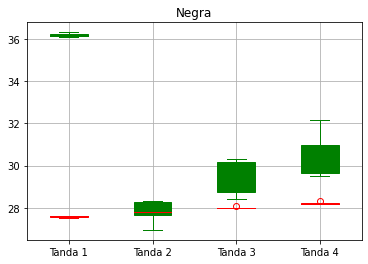

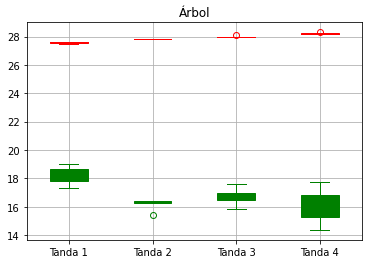

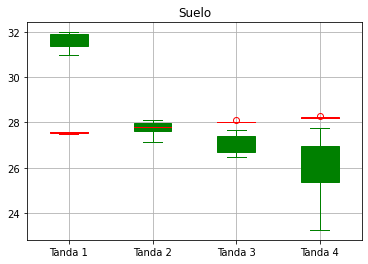

In [26]:
def telas_boxplot(tipo_tela, img_path, excel_path, sheet_duet):
    
    '''
    Función que genera un gráfico boxplot donde se muestra la media de la temperatura del sensor en los subconjuntos de imágenes
    junto con el subconjunto de temperaturas de cada imagen.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    
    Output:
    - Gráfico boxplot
    
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)

    image_time = []
    num1 = int()
    num2 = int()
    num3 = int()
    num4 = int()
    temp_sensor = []
    # Aquí, se extraen las horas de las imágenes tomadas
    for fname in sorted(os.listdir(img_path)):
        if fname.endswith('tif'):

            tif = tf.TiffFile(os.path.join(img_path, fname))

    # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "ExifTag":




                        # Se añaden a la lista en formato hora, minutos y segundos
                        if int(tag_value['DateTimeOriginal'][14:16])<=40 and int(tag_value['DateTimeOriginal'][14:16])>30:
                            num1 += 1
                            
                            
                        
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=45 and int(tag_value['DateTimeOriginal'][14:16])>=44:
                            num2+=1
                           
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=2 and int(tag_value['DateTimeOriginal'][14:16])>=0:
                            num3+=1
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=9 and int(tag_value['DateTimeOriginal'][14:16])>=7:
                            num4+=1
                    
                    # Temp sensor
                    if tag_name == "XMP":
                        dict_tot = xmltodict.parse(tag_value)
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        
                        # Temperatura del sensor
                        sens = float(dict2['@Camera:SensorTemperature'])
                        temp_sensor.append(sens)
     


    lista_analisis = df[df['tela'] == tipo_tela]['mean']
    c = 'green'
    r = 'red'
    plt.boxplot([lista_analisis[0:num1], lista_analisis[num1:num1 + num2], lista_analisis[num1 + num2:num1 + num2 + num3], 
                 lista_analisis[num1+num2+num3:num1+num2+num3 + num4]], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
    plt.boxplot([temp_sensor[0:num1], temp_sensor[num1:num1 + num2], temp_sensor[num1 + num2:num1 + num2 + num3], 
               temp_sensor[num1+num2+num3:num1+num2+num3 + num4]], patch_artist=True,
            boxprops=dict(facecolor=r, color=r),
            capprops=dict(color=r),
            whiskerprops=dict(color=r),
            flierprops=dict(color=r, markeredgecolor=r),
            medianprops=dict(color=r),)
    plt.xticks([1, 2, 3, 4], ['Tanda 1', 'Tanda 2', 'Tanda 3', 'Tanda 4'])
    plt.title(tipo_tela)
    plt.grid()
    plt.show()


telas_boxplot('Blanca', telas_img, telas_path, 'Telas_duet')
telas_boxplot('Negra', telas_img, telas_path, 'Telas_duet')
telas_boxplot('Árbol', telas_img, telas_path, 'Telas_duet')
telas_boxplot('Suelo', telas_img, telas_path, 'Telas_duet')

Se aplicará la misma función de temperatura por tandas con la temperatura media del sensor. En este caso, los grupos se dividirán en 3 bien definidos en la anterior función. -En este caso se tienen que llevar a cabo dos funciones ya que la serie temporal no es la misma.

In [27]:
# Regadío
def telas_boxplotRegadio(tipo_tela, excel_path, sheet_duet):
    
    '''
    Función que genera un gráfico boxplot donde se muestra la media de la temperatura del sensor en los subconjuntos de imágenes
    junto con el subconjunto de temperaturas de cada imagen.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    
    Output:
    - Gráfico boxplot
    
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_tela = df[df['tela'] == tipo_tela]

    image_time = []
    sensor = []
    num1 = int()
    num2 = int()
    num3 = int()
    temp_sensor = []
    # Aquí, se extraen las horas de las imágenes tomadas
    
    for horas in df_tela['Hora']:
        # Seleccionan los índices de los subconjuntos de datos
        if int(horas[3:5])<=50 and int(horas[3:5])>40:
                num1 += 1




        elif int(horas[3:5])<=55 and int(horas[3:5])>50:
                num2+=1


        elif int(horas[3:5])<=10 and int(horas[3:5])>=0:
                num3+=1
                            


    lista_analisis = df_tela['mean']
    temp_sensor = df_tela['Sensor']
    
    c = 'green'
    r = 'red'
    plt.boxplot([lista_analisis[0:num1], lista_analisis[num1:num1 + num2], lista_analisis[num1 + num2:num1 + num2 + num3]], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
    plt.boxplot([temp_sensor[0:num1], temp_sensor[num1:num1 + num2], temp_sensor[num1 + num2:num1 + num2 + num3]], patch_artist=True,
            boxprops=dict(facecolor=r, color=r),
            capprops=dict(color=r),
            whiskerprops=dict(color=r),
            flierprops=dict(color=r, markeredgecolor=r),
            medianprops=dict(color=r),)
    plt.xticks([1, 2, 3], ['Tanda 1', 'Tanda 2', 'Tanda 3'])
    plt.title('Regadío tela ' + tipo_tela)
    plt.grid()
    plt.show()
 


def telas_boxplotSecano(tipo_tela, excel_path, sheet_duet):
    
    '''
    Función que genera un gráfico boxplot donde se muestra la media de la temperatura del sensor en los subconjuntos de imágenes
    junto con el subconjunto de temperaturas de cada imagen.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    
    Output:
    - Gráfico boxplot
    
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_tela = df[df['tela'] == tipo_tela]

    image_time = []
    sensor = []
    num1 = int()
    num2 = int()
    num3 = int()
    temp_sensor = []
    # Aquí, se extraen las horas de las imágenes tomadas
    
    for horas in df_tela['Hora']:
        # Seleccionan los índices de los subconjuntos de datos
        if int(horas[3:5])<=31 and int(horas[3:5])>29:
                num1 += 1




        elif int(horas[3:5])<=33 and int(horas[3:5])>31:
                num2+=1


        elif int(horas[3:5])<=36 and int(horas[3:5])>=33:
                num3+=1
                            


    lista_analisis = df_tela['mean']
    temp_sensor = df_tela['Sensor']
    
    c = 'green'
    r = 'red'
    plt.boxplot([lista_analisis[0:num1], lista_analisis[num1:num1 + num2], lista_analisis[num1 + num2:num1 + num2 + num3]], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
    plt.boxplot([temp_sensor[0:num1], temp_sensor[num1:num1 + num2], temp_sensor[num1 + num2:num1 + num2 + num3]], patch_artist=True,
            boxprops=dict(facecolor=r, color=r),
            capprops=dict(color=r),
            whiskerprops=dict(color=r),
            flierprops=dict(color=r, markeredgecolor=r),
            medianprops=dict(color=r),)
    plt.xticks([1, 2, 3], ['Tanda 1', 'Tanda 2', 'Tanda 3'])
    plt.title('Secano tela ' + tipo_tela)
    plt.grid()
    plt.show()
  

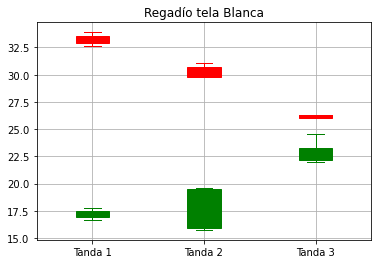

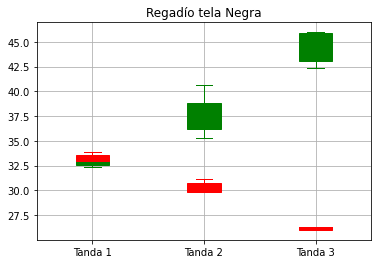

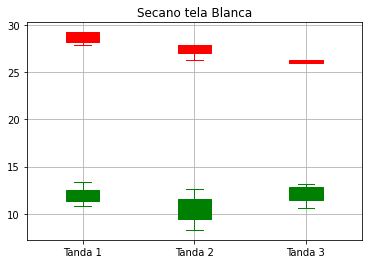

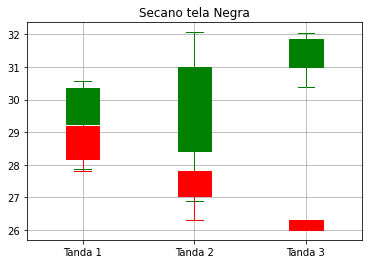

In [28]:
# Se aplica con el dataset de regadio
telas_boxplotRegadio('Blanca', excel_r,'Telas_duet')
telas_boxplotRegadio('Negra', excel_r,'Telas_duet')

telas_boxplotSecano('Blanca', excel_s,'Telas_duet')
telas_boxplotSecano('Negra', excel_s,'Telas_duet')

# Roll, coordenada y diferencia en las temperaturas

Función que grafica la diferencia de temperaturas entre la real y la hipotética con el roll del avión en el momento de la toma de imágenes. Para ello se tomarán los dos grupos últimos como uno solo ya que es donde menos variabilidad hay y, por tanto, se realiza la media de las 3 últimas temperaturas reales.

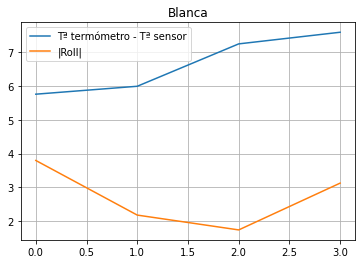

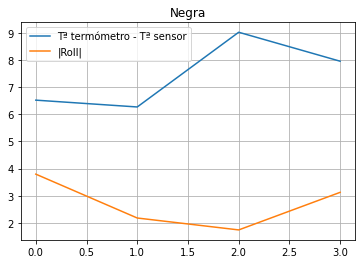

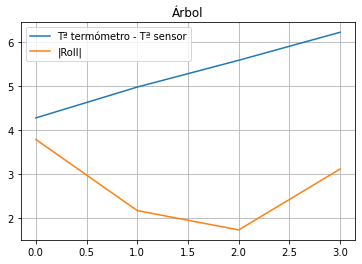

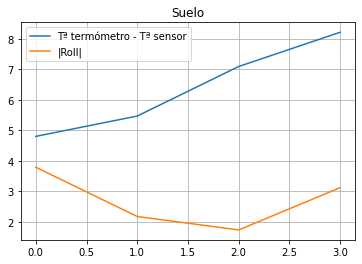

In [29]:
def roll_temp(tipo_tela, img_path, excel_path, sheet_duet,sheet_termo):
    
    '''
    Función que devuelve un gráfico comparando el ángulo roll del dron con la diferencia de la temperatura
    entre el termómetro y la captada por la cámara.
    
    Intputs:
    - tipo_tela = 'Blanca', 'Negra', 'Árbol', 'Suelo'
    - img_path = Directorio donde se encuentran las imágenes
    - excel_path = Directorio donde se encuentra el excel con las temperaturas reales e hipotéticas (cada una en un sheet)
    - sheet_duet = Sheet del excel donde se encuentran los datos hipotéticos
    - sheet_termo = Sheet del excel donde se encuentran los datos reales
    
    Output:
    - Gráfico que muestra el roll medio de cada subconjunto de datos junto con la diferencia de temperatura media entre la real
    y la hipotética de cada subconjunto
    '''

    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_termo = pd.read_excel(excel_path, sheet_name = sheet_termo)

    image_time = []
    num1 = int()
    num2 = int()
    num3 = int()
    num4 = int()
    roll = []
    # Aquí, se extraen las horas de las imágenes tomadas
    for fname in sorted(os.listdir(img_path)):
        if fname.endswith('tif'):

            tif = tf.TiffFile(os.path.join(img_path, fname))

    # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "ExifTag":




                        # Numeros que se usarán para determinar los subconjuntos de datos (se comparan los minutos con
                        # números puestos para diferenciar los distintos eventos horarios)
                        if int(tag_value['DateTimeOriginal'][14:16])<=40 and int(tag_value['DateTimeOriginal'][14:16])>30:
                            num1 += 1
                            
                            
                        
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=45 and int(tag_value['DateTimeOriginal'][14:16])>=44:
                            num2+=1
                           
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=2 and int(tag_value['DateTimeOriginal'][14:16])>=0:
                            num3+=1
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=9 and int(tag_value['DateTimeOriginal'][14:16])>=7:
                            num4+=1
                            
                    if tag_name == "XMP":
                        dict_tot = xmltodict.parse(tag_value)
                        dict2=(dict_tot['x:xmpmeta']['rdf:RDF']['rdf:Description'])
                        # Roll
                        r = float(dict2['@Camera:Roll'])
                        
                        # Hacemos que todos los roll sean positivos
                        if r < 0:
                            r = -1 * r
                        roll.append(r)
                        
                        
    # Se definen los conjuntos de datos con los nuevos parámetros para roll
    roll_1 = np.mean(roll[0:num1])
    roll_2 = np.mean(roll[num1:num1 + num2])
    roll_3 = np.mean(roll[num1 + num2:num1 + num2 + num3])
    roll_4 = np.mean(roll[num1 + num2 + num3:])
    
    # Se resta la media de la temperatura real por grupo por la media de la temperatura hipotética de cada grupo
    temp = df[df['tela'] == tipo_tela]['mean']
    temp_real = df_termo[tipo_tela]
    
    # Temperaturas de las imágenes por grupos y con las medias
    temp_1 = np.mean(temp[0:num1])
    temp_2 = np.mean(temp[num1:num1 + num2])
    temp_3 = np.mean(temp[num1 + num2:num1 + num2 + num3])
    temp_4 = np.mean(temp[num1 + num2 + num3:])
    
    # Temperaturas reales (media de las últimas 3 temperaturas)
    temp_r1 = temp_real[0]
    temp_r2 = temp_real[1]
    temp_r3 = np.mean(temp_real[2:])
    temp_r4 = temp_r3
    
    
    # Se grafica
    plt.plot([temp_r1-temp_1, temp_r2-temp_2, temp_r3-temp_3, temp_r4-temp_4], '-', label ='Tª termómetro - Tª sensor')
    plt.plot([roll_1, roll_2, roll_3, roll_4], '-', label = '|Roll|')
    plt.grid()
    plt.legend(loc ='best')
    plt.title(tipo_tela)
    plt.show()
    
roll_temp('Blanca', telas_img, telas_path, 'Telas_duet', 'Telas_reales')
roll_temp('Negra', telas_img, telas_path, 'Telas_duet', 'Telas_reales')
roll_temp('Árbol', telas_img, telas_path, 'Telas_duet', 'Telas_reales')
roll_temp('Suelo', telas_img, telas_path, 'Telas_duet', 'Telas_reales')

# Boxplot temp reales Vs temp hipotéticas y gráfico diferencia coordenadas

Todos los agrupamientos se llevarán a cabo con el mismo criterio que en la función roll_temp.

Se sabe experimentalmente, que en Qgis el centro de coordenadas relativo corresponde a x = 32.32, y = 25.378.

La corrección se leva a cabo con la ley de Stefan-Boltzmann

Tbr^4 = ε Ts^4 + (1 – ε) Tbg4 (Temperaturas en Kelvin)

Tbg = temperatura de background y en este caso es la media de todas las temperaturas del cielo que se cogieron el día del vuelo = -27.905

También crea una lista con los valores de temperatura real para cada tela 

In [30]:
def boxplot_temps(name,tipo_tela, img_path, excel_path, sheet_duet,sheet_termo, emiss, Tbg, offset = 0, coord = False, correct = False):
    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_termo = pd.read_excel(excel_path, sheet_name = sheet_termo)

    image_time = []
    num1 = int()
    num2 = int()
    num3 = int()
    num4 = int()
    roll = []
    corregido = '. No'
    final_list =[]
    temp_corr = []
    
    # Aquí, se extraen las horas de las imágenes tomadas
    for fname in sorted(os.listdir(img_path)):
        if fname.endswith('tif'):

            tif = tf.TiffFile(os.path.join(img_path, fname))

    # Iteramos en todas las tags
            for page in tif.pages:
                for tag in page.tags:
                    tag_name, tag_value = tag.name, tag.value

                    if tag_name == "ExifTag":




                        # Numeros que se usarán para determinar los subconjuntos de datos (se comparan los minutos con
                        # números puestos para diferenciar los distintos eventos horarios)
                        if int(tag_value['DateTimeOriginal'][14:16])<=40 and int(tag_value['DateTimeOriginal'][14:16])>30:
                            num1 += 1
                            
                            
                        
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=45 and int(tag_value['DateTimeOriginal'][14:16])>=44:
                            num2+=1
                           
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=2 and int(tag_value['DateTimeOriginal'][14:16])>=0:
                            num3+=1
                            
                        elif int(tag_value['DateTimeOriginal'][14:16])<=9 and int(tag_value['DateTimeOriginal'][14:16])>=7:
                            num4+=1
                            
    # Se resta la media de la temperatura real por grupo por la media de la temperatura hipotética de cada grupo
    temp = df[df['tela'] == tipo_tela]['mean']
    temp_real = df_termo[tipo_tela]
    
    if correct == True:
        tempcorr = []
        Kbg = Tbg + 273
        
        # Corrección telas sensor 
        for i in temp:
            
            # Conversión a Kelvin
            K = i + 273.0
            
            # Corrección atmosférica
            corr = ((K**4.0 - (1.0-emiss)*Kbg**4.0)/emiss)**(1/4)
            
            # Transformación a grados
            grad = corr - 273.0
            
            tempcorr.append(grad)
        temp = tempcorr
        corregido = '. Sí'
        temp_corr = temp   
    else:
        pass
     # Temperaturas de las imágenes por grupos y con las medias
    temp_1 = temp[0:num1]
    temp_2 = temp[num1:num1 + num2]
    temp_3 = temp[num1 + num2:num1 + num2 + num3]
    temp_4 = temp[num1 + num2 + num3:]
    
    
    
    # Temperaturas reales (media de las últimas 3 temperaturas)
    temp_r1 = temp_real[0]
    temp_r2 = temp_real[1]
    temp_r3 = temp_real[2:]
    temp_r4 = temp_r3
    
    # Incluir la temperatura real en una lista las veces necesarias para compararlas con cada temperatura de tela hipotética
    for i in range(0,num1):
        final_list.append(np.mean(temp_r1))
        
    for j in range(0,num2):
        final_list.append(np.mean(temp_r2))
        
    for z in range(0,num3):
        final_list.append(np.mean(temp_r3))
        
    for y in range(0,num4):
        final_list.append(np.mean(temp_r4))
    
    # Diferencias entre temperaturas reales e hipotéticas
    diff1 = np.mean(temp_r1) - np.mean(temp_1)
    diff2 = np.mean(temp_r2) - np.mean(temp_2)
    diff3 = np.mean(temp_r3) - np.mean(temp_3)
    diff4 = np.mean(temp_r4) - np.mean(temp_4)
    
    diff = [diff1,diff2,diff3,diff4]
    
    # Coordenadas
    centroX = 32.32
    centroY = 25.378
    coordX = df[df['tela'] == tipo_tela]['coordenada_x']
    coordY = df[df['tela'] == tipo_tela]['coordenada_y']
    
    # Resta de cada coordenada por la coordenada del centro de la imagen
    diffX = []
    diffY = []
    for i in coordX:
        dx = i-centroX
        diffX.append(dx)
        
    for z in coordY:
        dy = z - centroY
        diffY.append(dy)
        
    # Agrupación de las coordenadas por medio de media en cada grupo
    coordX_1 = np.mean(diffX[0:num1])
    coordX_2 = np.mean(diffX[num1:num1 + num2])
    coordX_3 = np.mean(diffX[num1 + num2:num1 + num2 + num3])
    coordX_4 = np.mean(diffX[num1 + num2 + num3:])
    
    coordY_1 = np.mean(diffY[0:num1])
    coordY_2 = np.mean(diffY[num1:num1 + num2])
    coordY_3 = np.mean(diffY[num1 + num2:num1 + num2 + num3])
    coordY_4 = np.mean(diffY[num1 + num2 + num3:])
    
    # Boxplot temperaturas
    #plt.subplot(2, 1, 1)
    c = 'green'
    r = 'blue'
    plt.boxplot([temp_1,temp_2,temp_3 ,temp_4], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
    plt.boxplot([temp_r1, temp_r2, temp_r3, temp_r4], patch_artist=True,
            boxprops=dict(facecolor=r, color=r),
            capprops=dict(color=r),
            whiskerprops=dict(color=r),
            flierprops=dict(color=r, markeredgecolor=r),
            medianprops=dict(color=r),)
    plt.xticks([1, 2, 3, 4], ['Subgrupo 1', 'Subgrupo 2', 'Subgrupo 3', 'Subgrupo 4'])
    plt.title(name + ' ' + tipo_tela + corregido+' corregida')
    plt.grid()
    #plt.savefig(name + ' ' + tipo_tela + corregido+ ' BxTemp_realVsTemp_hipotetica.png', dpi = 300)
    plt.show()
    
    # Gráfico de las coordenadas
    if coord == True:
        X = [coordX_1,coordX_2,coordX_3,coordX_4]
        Y = [coordY_1,coordY_2,coordY_3,coordY_4]
        name = ['Tanda 1', 'Tanda 2', 'Tanda 3', 'Tanda 4']
        fig, ax = plt.subplots()
        #plt.subplot(2, 1, 2)
        ax.scatter(X, Y)
        plt.grid()
        plt.title(tipo_tela)

        for i, txt in enumerate(name):
            ax.annotate(txt, (X[i], Y[i]))
            
    return diff

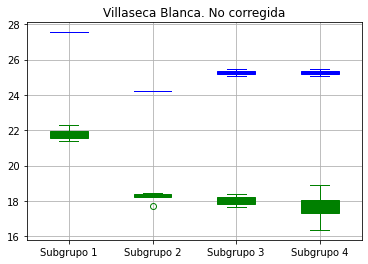

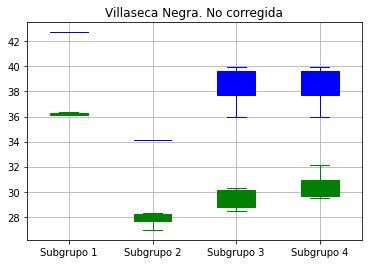

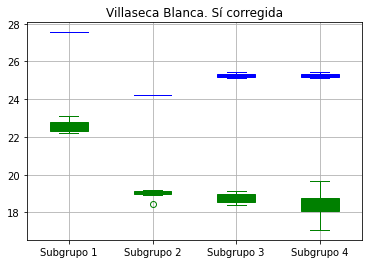

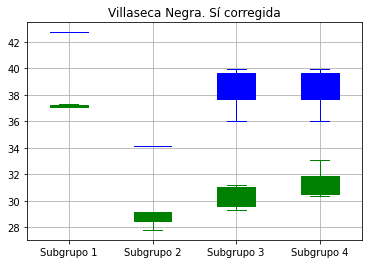

In [31]:
# Se generan los fráficos y se guardan las diferencias 
VillaB = boxplot_temps('Villaseca','Blanca', telas_img, telas_path, 'Telas_duet', 'Telas_reales',offset =0,  correct = False, emiss = 0.98, Tbg = -27.905)
VillaN = boxplot_temps('Villaseca','Negra', telas_img, telas_path, 'Telas_duet', 'Telas_reales',offset =0,  correct = False, emiss = 0.98, Tbg = -27.905)
VillaBS = boxplot_temps('Villaseca','Blanca', telas_img, telas_path, 'Telas_duet', 'Telas_reales',offset =0,  correct = True, emiss = 0.98, Tbg = -27.905)
VillaNS = boxplot_temps('Villaseca','Negra', telas_img, telas_path, 'Telas_duet', 'Telas_reales', offset =0,  correct = True,emiss = 0.98, Tbg = -27.905)

Como se ha hecho hasta ahora, se definirán dos funciones para hallar el offset necesario. Como es muy larga la función, se fusionará en una sola donde existirá una opción de elegir el vuelo que utilizar.

In [32]:
def boxplot_tempsTrigo(tipo_tela, excel_path, sheet_duet,sheet_termo, emiss, Tbg,vuelo, offset = 0, coord = False, correct = False):
    df = pd.read_excel(excel_path, sheet_name = sheet_duet)
    df_termo = pd.read_excel(excel_path, sheet_name = sheet_termo)
    df_tela = df[df['tela'] == tipo_tela]

    image_time = []
    num1 = int()
    num2 = int()
    num3 = int()
    num4 = int()
    roll = []
    corregido = '. No '
    final_list = []
    lista_cor = []
    
    if vuelo == 'Secano':
        
        for horas in df_tela['Hora']:
            
        # Seleccionan los índices de los subconjuntos de datos
            if int(horas[3:5])<=31 and int(horas[3:5])>28:
                    num1 += 1




            elif int(horas[3:5])<=33 and int(horas[3:5])>31:
                    num2+=1


            elif int(horas[3:5])<=40 and int(horas[3:5])>32:
                    num3+=1
                    
    elif vuelo == 'Regadío':
        for horas in df_tela['Hora']:
            
        # Seleccionan los índices de los subconjuntos de datos
            if int(horas[3:5])<=50 and int(horas[3:5])>40:
                    num1 += 1




            elif int(horas[3:5])<=55 and int(horas[3:5])>50:
                    num2+=1


            elif int(horas[3:5])<=10 and int(horas[3:5])>=0:
                    num3+=1

    # Se resta la media de la temperatura real por grupo por la media de la temperatura hipotética de cada grupo
    temp = df_tela['mean']
    temp_real = df_termo[tipo_tela]
    
    if correct == True:
        tempcorr = []
        Kbg = Tbg + 273
        
        # Corrección telas sensor 
        for i in temp:
            
            # Conversión a Kelvin
            K = i + 273.0
            
            # Corrección atmosférica
            corr = ((K**4.0 - (1.0-emiss)*Kbg**4.0)/emiss)**(1/4)
            
            # Transformación a grados
            grad = corr - 273.0
            
    
            
            tempcorr.append(grad)
        temp = tempcorr
        corregido = '. Sí '
        list_cor = temp
    else:
        pass
    
     # Temperaturas de las imágenes por grupos y con las medias
    temp_1 = temp[0:num1]
    temp_2 = temp[num1:num1 + num2]
    temp_3 = temp[num1 + num2:num1 + num2 + num3]
    
    
    # Temperaturas reales (media de las últimas 3 temperaturas)
    temp_r1 = [temp_real[0]]
    temp_r2 = [temp_real[1]]
    temp_r3 = [temp_real[2]]
    
    # Diferencia entre temperatura real e hipotética
    diff = []
    diff1 = temp_r1[0] - np.mean(temp_1)
    diff2 = temp_r2[0] - np.mean(temp_2)
    diff3 = temp_r3[0] - np.mean(temp_3)
    diff.append(diff1)
    diff.append(diff2)
    diff.append(diff3)
    
    # Incluir la temperatura real en una lista las veces necesarias para compararlas con cada temperatura de tela hipotética
    for i in range(0,num1):
        final_list.append(np.mean(temp_r1))
        
    for j in range(0,num2):
        final_list.append(np.mean(temp_r2))
        
    for z in range(0,num3):
        final_list.append(np.mean(temp_r3))
        
    
    # Coordenadas
    centroX = 32.32
    centroY = 25.378
    coordX = df[df['tela'] == tipo_tela]['coordenada_x']
    coordY = df[df['tela'] == tipo_tela]['coordenada_y']
    
    # Resta de cada coordenada por la coordenada del centro de la imagen
    diffX = []
    diffY = []
    for i in coordX:
        dx = i-centroX
        diffX.append(dx)
        
    for z in coordY:
        dy = z - centroY
        diffY.append(dy)
        
    # Agrupación de las coordenadas por medio de media en cada grupo
    coordX_1 = np.mean(diffX[0:num1])
    coordX_2 = np.mean(diffX[num1:num1 + num2])
    coordX_3 = np.mean(diffX[num1 + num2:num1 + num2 + num3])
    
    coordY_1 = np.mean(diffY[0:num1])
    coordY_2 = np.mean(diffY[num1:num1 + num2])
    coordY_3 = np.mean(diffY[num1 + num2:num1 + num2 + num3])

    
    # Boxplot temperaturas
    c = 'green'
    r = 'blue'
    plt.boxplot([temp_1,temp_2,temp_3], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
    plt.boxplot([temp_r1, temp_r2, temp_r3], patch_artist=True,
            boxprops=dict(facecolor=r, color=r),
            capprops=dict(color=r),
            whiskerprops=dict(color=r),
            flierprops=dict(color=r, markeredgecolor=r),
            medianprops=dict(color=r),)
    plt.xticks([1, 2, 3], ['Subgrupo 1', 'Subgrupo 2', 'Subgrupo 3'])
    plt.title(vuelo + ' tela ' + tipo_tela + corregido + 'corregido')
    plt.grid()
    plt.savefig(vuelo + ' ' + tipo_tela + corregido+ ' BxTemp_realVsTemp_hipotetica.png', dpi = 300)
    plt.show()
    
    # Gráfico de las coordenadas
    if coord == True:
        X = [coordX_1,coordX_2,coordX_3]
        Y = [coordY_1,coordY_2,coordY_3]
        name = ['Tanda 1', 'Tanda 2', 'Tanda 3']
        fig, ax = plt.subplots()
        
        ax.scatter(X, Y)
        plt.grid()
        plt.title(vuelo + ' tela ' +tipo_tela)

        for i, txt in enumerate(name):
            ax.annotate(txt, (X[i], Y[i]))
            
    return diff

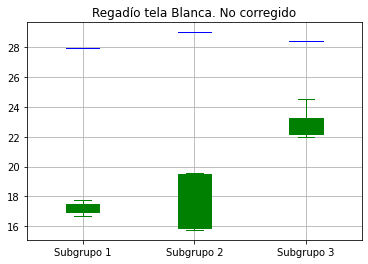

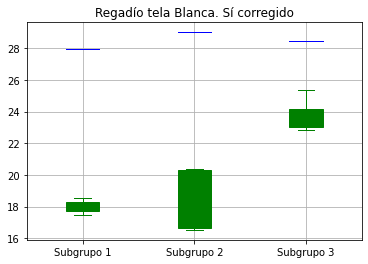

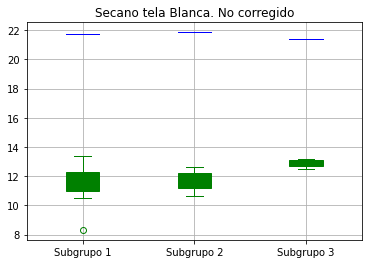

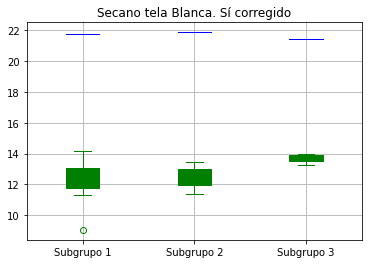

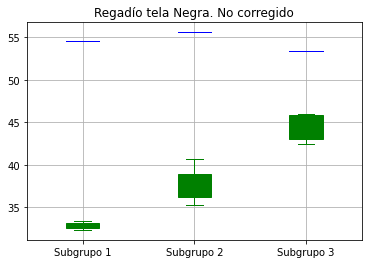

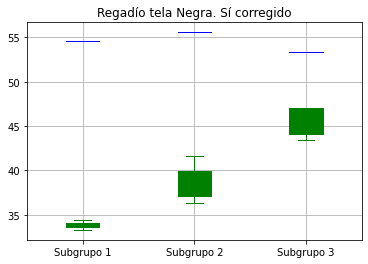

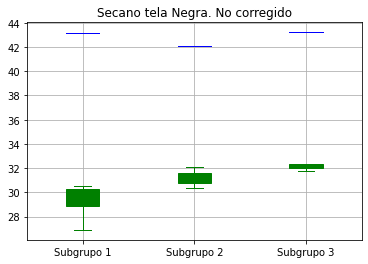

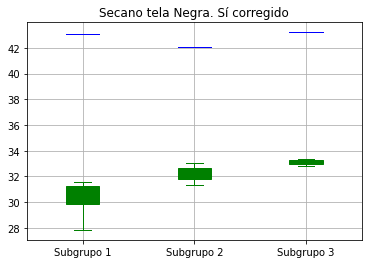

In [33]:
# Regadío tela blanca con y sin corregir
excel_r = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\temp_regadio.xlsx'
excel_s = r'\Users\Usuario\Documents\Máster Bioinformática y Bioestadística\Segundo semestre\TFM\Datos a utilizar TFM\Excels en bruto\temp_secano.xlsx'

regbno=boxplot_tempsTrigo('Blanca', excel_r, 'Telas_duet','Telas_reales', 0.98, -33.9,'Regadío', offset = 0, coord = False, correct = False)
regbsi=boxplot_tempsTrigo('Blanca', excel_r, 'Telas_duet','Telas_reales', 0.98, -33.9,'Regadío', offset = 0, coord = False, correct = True)

#Secano tela blanca con y sin corregir
secbno= boxplot_tempsTrigo('Blanca', excel_s, 'Telas_duet','Telas_reales', 0.98, -38,'Secano', offset = 0, coord = False, correct = False)
secbsi = boxplot_tempsTrigo('Blanca', excel_s, 'Telas_duet','Telas_reales', 0.98, -38,'Secano', offset = 0, coord = False, correct = True)

# Regadío tela negra con y sin corregir
regnno = boxplot_tempsTrigo('Negra', excel_r, 'Telas_duet','Telas_reales', 0.98, -33.9,'Regadío', offset = 0, coord = False, correct = False)
regnsi = boxplot_tempsTrigo('Negra', excel_r, 'Telas_duet','Telas_reales', 0.98, -33.9,'Regadío', offset = 0, coord = False, correct = True)

# Secano tela negra con y sin corregir
secnno = boxplot_tempsTrigo('Negra', excel_s, 'Telas_duet','Telas_reales', 0.98, -38,'Secano', offset = 0, coord = False, correct = False)
secnsi = boxplot_tempsTrigo('Negra', excel_s, 'Telas_duet','Telas_reales', 0.98, -38,'Secano', offset = 0, correct = True)